# Setup

In [1]:
# Common Imports
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

# To make the notebook's output stable across runs
random_seed = 12182017
np.random.seed(random_seed)

# To plot pretty figures
%matplotlib inline
#plt.rcParams['axes.labelsize'] = 14
#plt.rcParams['xtick.labelsize'] = 12
#plt.rcParams['ytick.labelsize'] = 12
sns.set()

## Helper Functions

In [2]:
def notebook_setup(device):
    '''
    Sets the PROJECT_ROOT_DIR, DOWNLOAD_ROOT, DATASET_PATH based on device
    Returns a tuple.
    '''
    if device == 'XPS':
        PROJECT_ROOT_DIR = r'C:\Users\Adrian\Projects\Consulting\Machine-Learning-Examples'
        DOWNLOAD_ROOT = r"C:\Users\Adrian\Google Drive\Datasets"
    elif device == 'Workstation':
        PROJECT_ROOT_DIR = r'C:\Users\aperez\Projects\Consulting\Machine-Learning-Examples'
        DOWNLOAD_ROOT = r"C:\Users\aperez\Google Drive\Datasets"        
    return PROJECT_ROOT_DIR, DOWNLOAD_ROOT

def find_datasets(vistor_path):
    '''
    Finds all the dataset (.csv) in vistor_path.
    Returns a list.
    '''
    dataset_list = []
    datasets = glob.glob(os.path.join(vistor_path, '*.csv'))
    for dataset in datasets:
        dataset_list.append(os.path.splitext(os.path.split(dataset)[1])[0])   
    return dataset_list

def load_vistor_data(dataset, vistor_path):
    '''
    Loads a dataset
    Returns a pandas dataframe.
    '''
    csv_path = os.path.join(vistor_path, dataset+".csv")
    return pd.read_csv(csv_path)

def load_all_vistor_data(vistor_path):
    '''
    Loads all the resturuant-vistor datasets in vistor_path
    Returns 8 panda dataframes
    '''
    dataset_dict = {}
    dataset_list = find_datasets(vistor_path)
    for dataset in dataset_list:
        dataset_dict[dataset] = load_vistor_data(dataset, vistor_path)
    return dataset_dict

def rmsle(y, y_pred):
    '''
    A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
    '''
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

## Configure Notebook & Load Raw Data

In [3]:
# Configures notebook to device
PROJECT_ROOT_DIR, DOWNLOAD_ROOT = notebook_setup('Workstation')

In [3]:
# Configures notebook to device
PROJECT_ROOT_DIR, DOWNLOAD_ROOT = notebook_setup('XPS')

In [4]:
# Where to save the fiqures
PROJECT_ID = 'restaurant-vistors'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, PROJECT_ID, "images")

# Where to save the data
VISTOR_PATH = os.path.join(DOWNLOAD_ROOT, "Restaurant-Visitors")

In [5]:
# Loads all data into dict
dataset_dict = load_all_vistor_data(VISTOR_PATH)

# Loads each dataset into pandas df
air_reserve_df = dataset_dict['air_reserve']
air_store_info_df = dataset_dict['air_store_info']
air_visit_data_df = dataset_dict['air_visit_data']
date_info_df = dataset_dict['date_info']
hpg_reserve_df = dataset_dict['hpg_reserve']
hpg_store_info_df = dataset_dict['hpg_store_info']
sample_submission_df = dataset_dict['sample_submission']
store_id_relation_df = dataset_dict['store_id_relation']

# Data Exploration

In [6]:
air_reserve_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [7]:
air_store_info_df.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [8]:
air_visit_data_df.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [9]:
date_info_df.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [10]:
hpg_reserve_df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [11]:
hpg_store_info_df.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [12]:
store_id_relation_df.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [13]:
sample_submission_df.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


<b>Genre Definations</b>
* Izakaya (居酒屋) (Japanese: [izakaja], ee-ZAH-ka-yah)[1] is a type of informal Japanese gastropub. They are casual places for after-work drinking. They have been compared to Irish pubs, tapas bars and early American saloons and taverns.[2]
* Yakiniku (焼き肉 or 焼肉), meaning "grilled meat", is a Japanese term that, in its broadest sense, refers to grilled meat cuisine
* Okonomiyaki (お好み焼き o-konomi-yaki) (About this sound listen (help·info)) is a Japanese savory pancake containing a variety of ingredients. 
* Monjayaki (もんじゃ焼き, often called simply "monja") is a type of Japanese pan-fried batter, popular in the Kantō region, similar to okonomiyaki, but that uses different liquid ingredients.
* Teppanyaki (鉄板焼き teppan-yaki) is a style of Japanese cuisine that uses an iron griddle to cook food.

In [ ]:
air_store_info_df['air_genre_name'].value_counts()

In [ ]:
air_store_info_df['air_genre_name'].value_counts().plot.bar()

In [ ]:
air_store_info_df['air_area_name'].value_counts()

In [ ]:
air_store_info_df.head()

In [ ]:
air_store_info_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(13,8))

In [ ]:
air_visit_data_df['visit_date'].value_counts().sort_index()

In [ ]:
air_visit_data_df['visit_date'].value_counts().sort_index().plot(figsize=(20,8))

In [ ]:
hpg_store_info_df['hpg_genre_name'].value_counts()

In [ ]:
hpg_store_info_df['hpg_genre_name'].value_counts().plot.bar()

In [ ]:
hpg_store_info_df['hpg_area_name'].value_counts()

In [ ]:
hpg_store_info_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(13,8))

# Pre-processing

## air_visit_data_df - Remove outliers

With Outliers


,visitors
count,252108.000000
mean,20.973761
std,16.757007
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,877.000000


Without Outliers


,visitors
count,251843.000000
mean,20.826567
std,15.863126
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,114.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000275E4C54748>]], dtype=object)

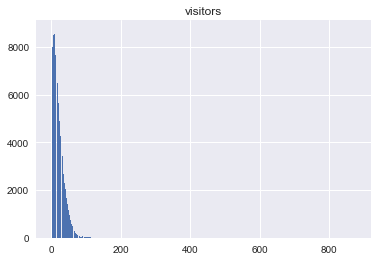

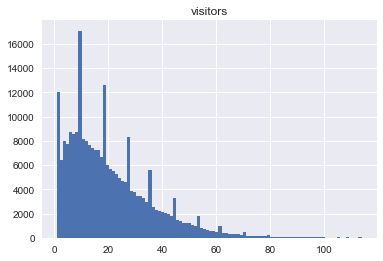

In [6]:
print('With Outliers')
display(air_visit_data_df.describe())
air_visit_data_df.hist('visitors', bins=1000)

# Removes 'visitors' over the 99.9% Quantile
air_visit_data_df = air_visit_data_df[air_visit_data_df['visitors'] < air_visit_data_df['visitors'].quantile(q=.999)]

print('Without Outliers')
display(air_visit_data_df.describe())
air_visit_data_df.hist('visitors', bins=100)

## 'visit_day' features

In [7]:
# Renames 'calendar_date' to 'visit_date'
date_info_df.rename(index=str, columns={"calendar_date":"visit_date"}, inplace=True)
# Find months of 'calendar_date'
date_info_df['numeric_month'] = pd.DatetimeIndex(date_info_df["visit_date"]).month
# Convert 'numeric_month' to str month value
months_df = pd.DataFrame(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']).reset_index()
months_df['index'] = months_df['index'] + 1
months_df.rename(index=str, columns={'index':'numeric_month', 0:'month'}, inplace=True)
# Adds year
date_info_df['visit_year'] = pd.DatetimeIndex(date_info_df["visit_date"]).year
# Clean up unused columns
date_info_df = date_info_df.merge(months_df, on='numeric_month')
date_info_df.drop('numeric_month', axis=1, inplace=True)
# Make dummy variables for 'days_of_the_week'
#date_info_df = pd.get_dummies(date_info_df, columns=['day_of_week', 'month'])
date_info_df["visit_date"] = pd.DatetimeIndex(date_info_df["visit_date"]).date

date_info_df.head()

,visit_date,day_of_week,holiday_flg,visit_year,month
0,2016-01-01,Friday,1,2016,Jan
1,2016-01-02,Saturday,1,2016,Jan
2,2016-01-03,Sunday,1,2016,Jan
3,2016-01-04,Monday,0,2016,Jan
4,2016-01-05,Tuesday,0,2016,Jan


## Reservation Data

In [8]:
# Fields used to calculate statistics
air_reserve_df['visit_date'] = pd.DatetimeIndex(air_reserve_df['visit_datetime']).date
air_reserve_df['visit_time'] = pd.DatetimeIndex(air_reserve_df['visit_datetime']).time
air_reserve_df['reserve_date'] = pd.DatetimeIndex(air_reserve_df['reserve_datetime']).date
air_reserve_df['visit_hour'] = pd.DatetimeIndex(air_reserve_df['visit_datetime']).hour
# Calculates the seconds difference between when the reservation is made and when the establishment is visited
air_reserve_df['reserve_visit_difference'] = (pd.DatetimeIndex(air_reserve_df['visit_datetime']) - pd.DatetimeIndex(air_reserve_df['reserve_datetime'])) / np.timedelta64(1, 's')
# Groups data by 'air_store_id' and 'visit_date'
air_groups = air_reserve_df.groupby(['air_store_id', 'visit_date'])

# Fields used to calculate statistics
hpg_reserve_df['visit_date'] = pd.DatetimeIndex(hpg_reserve_df['visit_datetime']).date
hpg_reserve_df['visit_time'] = pd.DatetimeIndex(hpg_reserve_df['visit_datetime']).time
hpg_reserve_df['reserve_date'] = pd.DatetimeIndex(hpg_reserve_df['reserve_datetime']).date
hpg_reserve_df['visit_hour'] = pd.DatetimeIndex(hpg_reserve_df['visit_datetime']).hour
# Calculates the seconds difference between when the reservation is made and when the establishment is visited
hpg_reserve_df['reserve_visit_difference'] = (pd.DatetimeIndex(hpg_reserve_df['visit_datetime']) - pd.DatetimeIndex(hpg_reserve_df['reserve_datetime'])) / np.timedelta64(1, 's')
# Groups data by 'hpg_store_id' and 'visit_date'
hpg_groups = hpg_reserve_df.groupby(['hpg_store_id', 'visit_date'])

## Prepare submission data

In [18]:
# Creates dataframe for processing submission
prediction_df = pd.DataFrame()
# Extracts the 'air_store_id'
prediction_df['air_store_id'] = sample_submission_df['id'].str.extract('(.{20})_.+')
# Extacts the 'visit_date'
prediction_df['visit_date'] = pd.DatetimeIndex(sample_submission_df['id'].str.extract('.{20}_(.+)')).date
# Sets 'visitors' to 0 so these do not get dropped later on
prediction_df['visitors'] = 0

prediction_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,0
1,air_00a91d42b08b08d9,2017-04-24,0
2,air_00a91d42b08b08d9,2017-04-25,0
3,air_00a91d42b08b08d9,2017-04-26,0
4,air_00a91d42b08b08d9,2017-04-27,0


## restaurant_df

<b>restaurant_df:</b> vistor information that will extracted or engineered from current datasets to be used to predict future restaurant vistors.
* <i>air_store_id</i> - the restaurant's id in the air system
* <i>hpg_store_id</i> - the restaurant's id in the hpg system
* <i>area_name</i> - area to which the restaurant belongs (Provience, City, Area). Constructed from  'hpg_area_name' and 'air_area_name'
* <i>air_genre_name</i> - type of restaurant in the air system.
* <i>hpg_genre_name</i> - type of restaurant in the hpg system.
* <i>latitude</i> -  latitude of the area to which the restaurant belongs.
* <i>longtitude</i> - longtitude of the area to which the restaurant belongs.
* <i>visit_date</i> - date of observation.
* <i>numeric_month</i> month of the year (This is 12 dummy variables).
* <i>day_of_week</i> - day of the week of visit_date (This is seven dummy variables).
* <i>holiday_flg</i> - is the day a holiday in Japan
* <i>air_daily_total_reserve_visitors</i> - the daily total number of visitors from reservations from the air system
* <i>air_daily_total_reserves</i> - the daily total number of reservations from the air system
* <i>air_daily_avg_reserve_visitors</i> - the daily average number of visitors per visit from the air system
* <i>air_daily_avg_visit_time</i> - the daily average time a reservation is made from the air point-of-sale system
* <i>air_avg_reserve_visit_difference</i> - the daily average seconds difference between when the reservations is made and the visit is in made on the air system.
* <i>hpg_daily_avg_visit_time</i> - the daily average of the time of the reservation from the hpg system
* <i>hpg_daily_total_visit_time</i> - the daily total of reservations made with the hpg system
* <i>hpg_daily_avg_reserve_time</i> - the daily average of the time the reservation was made with the hpg system
* <i>hpg_reserve_total_visitors</i> - the daily total of number of visitors made reservation with the hpg system
* <i>hpg_reserce_avg_visitors</i> - the daily average of number of visitors made reservations with the hpg system
* <i>visitors</i> - the historical number of visitors to the restaurant on calender date. Value to be forcasted.

In [9]:
# Intiate the restaurant_df
restaurant_df = pd.DataFrame()
# Adds 'visit_date'
restaurant_df['visit_date'] = date_info_df['visit_date']
# Adds 'air_store_id' in air system
restaurant_df = restaurant_df.merge(air_reserve_df[['air_store_id', 'visit_date']], on='visit_date', how='outer')
# Adds 'air_store_id' with visitor data
restaurant_df = restaurant_df.merge(air_visit_data_df[['air_store_id', 'visit_date']], on=['air_store_id', 'visit_date'], how='outer')

# Adds the sample_submission data for processing
restaurant_df = restaurant_df.merge(prediction_df, on=['air_store_id', 'visit_date'], how='outer')
# Drops the 'visitors' feature
restaurant_df.drop('visitors', axis=1, inplace=True)

# Adds relationship between 'air_store_id' and 'hpg_store_id'
restaurant_df = restaurant_df.merge(store_id_relation_df, on='air_store_id', how='left')
# Adds 'hpg_store_id' in hpg system and not in air system
restaurant_df = restaurant_df.merge(hpg_reserve_df[['hpg_store_id', 'visit_date']], on=['hpg_store_id', 'visit_date'], how='outer')
restaurant_df.drop_duplicates(inplace=True)

# air_groups
# Adds 'air_daily_total_reserve_visitors'
restaurant_df = restaurant_df.merge(air_groups['reserve_visitors'].sum().reset_index(), on=['air_store_id', 'visit_date'], how='outer')
restaurant_df.rename(index=str, columns = {'reserve_visitors':'air_daily_total_reserve_visitors'}, inplace=True)
# Adds 'air_daily_total_reserves'
restaurant_df = restaurant_df.merge(air_groups['reserve_visitors'].count().reset_index(), on=['air_store_id', 'visit_date'], how='outer')
restaurant_df.rename(index=str, columns = {'reserve_visitors':'air_daily_total_reserves'}, inplace=True)
# Adds 'air_daily_avg_reserve_visitors'
restaurant_df['air_daily_avg_reserve_visitors'] = restaurant_df['air_daily_total_reserve_visitors']/restaurant_df['air_daily_total_reserves']
# Adds 'air_avg_reserve_visit_difference'
restaurant_df = restaurant_df.merge(air_groups['reserve_visit_difference'].mean().reset_index(), on=['air_store_id', 'visit_date'], how='outer')
restaurant_df.rename(index=str, columns = {'reserve_visit_difference':'air_avg_reserve_visit_difference'}, inplace=True)
# Adds 'air_daily_avg_visit_time' 
restaurant_df = restaurant_df.merge(air_groups['visit_hour'].mean().reset_index(), on=['air_store_id', 'visit_date'], how='outer')
restaurant_df.rename(index=str, columns = {'visit_hour':'air_daily_avg_visit_time'}, inplace=True)

# hpg_groups
# Adds 'hpg_daily_total_reserve_visitors'
restaurant_df = restaurant_df.merge(hpg_groups['reserve_visitors'].sum().reset_index(), on=['hpg_store_id', 'visit_date'], how='outer')
restaurant_df.rename(index=str, columns = {'reserve_visitors':'hpg_daily_total_reserve_visitors'}, inplace=True)
# Adds 'hpg_daily_total_reserves'
restaurant_df = restaurant_df.merge(hpg_groups['reserve_visitors'].count().reset_index(), on=['hpg_store_id', 'visit_date'], how='outer')
restaurant_df.rename(index=str, columns = {'reserve_visitors':'hpg_daily_total_reserves'}, inplace=True)
# Adds 'hpg_daily_avg_reserve_visitors'
restaurant_df['hpg_daily_avg_reserve_visitors'] = restaurant_df['hpg_daily_total_reserve_visitors']/restaurant_df['hpg_daily_total_reserves']
# Adds 'hpg_avg_reserve_visit_difference'
restaurant_df = restaurant_df.merge(hpg_groups['reserve_visit_difference'].mean().reset_index(), on=['hpg_store_id', 'visit_date'], how='outer')
restaurant_df.rename(index=str, columns = {'reserve_visit_difference':'hpg_avg_reserve_visit_difference'}, inplace=True)
# Adds 'hpg_daily_avg_visit_time' 
restaurant_df = restaurant_df.merge(hpg_groups['visit_hour'].mean().reset_index(), on=['hpg_store_id', 'visit_date'], how='outer')
restaurant_df.rename(index=str, columns = {'visit_hour':'hpg_daily_avg_visit_time'}, inplace=True)

# Fills in missing values for establishments not in system
reserve_df = restaurant_df.groupby('visit_date').mean()
# Correct 'visit_date'
air_visit_data_df["visit_date"] = pd.DatetimeIndex(air_visit_data_df["visit_date"]).date

# Adds the sample_submission data for merger
air_visit_data_df = air_visit_data_df.merge(prediction_df, on=['air_store_id', 'visit_date'], how='outer')
# Fills nans with zeros for combining two visitors features
air_visit_data_df.fillna(0, inplace=True)
# Combines visitors features
air_visit_data_df['visitors'] = air_visit_data_df['visitors_x']+air_visit_data_df['visitors_y']
# Drops bad visitor feautes
air_visit_data_df.drop(['visitors_x', 'visitors_y'], axis=1, inplace=True)

# Adds 'visitors' the pred variable
restaurant_df = restaurant_df.merge(air_visit_data_df, on=['air_store_id', 'visit_date'], how='outer')

# Adds 'air_genre_name', 'air_area_name', 'latitude', and 'longitude'
restaurant_df = restaurant_df.merge(air_store_info_df[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id')
# Adds 'hpg_genre_name'
restaurant_df = restaurant_df.merge(hpg_store_info_df[['hpg_store_id', 'hpg_genre_name']], on='hpg_store_id', how='outer')
# Removes rows wihtout visitors added from hpg system
restaurant_df = restaurant_df.loc[~restaurant_df['visitors'].isnull(), :]

C:\Users\aperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Genre Name Feature Extraction

Binary features created from 'air_genre_name' and 'hpg_genre_name'. 
* <i>'alcohol_served'</i> - is alochol served at the establishment.
* <i>'food_served'</i> - is food served at the establishment.
* <i>'themed_establishment'</i> - themed as amusement\karaoke\party establishment.
* <i>'asian_establishment'</i> - primarly serves Asian cusine or is an Asian style establishment.

In [83]:
restaurant_df['alcohol_served'] = np.NaN
restaurant_df['food_served'] = np.NaN
restaurant_df['themed_establishment'] = np.NaN
restaurant_df['asian_establishment'] = np.NaN

air_genres = list(restaurant_df['air_genre_name'].value_counts().index.values)
for genre in air_genres:
    # 'alcohol_served''
    if (genre in ['Izakaya', 'Dining bar', 'Bar/Cocktail',  'Karaoke/Party']): 
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'alcohol_served'] = 1
    else:
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'alcohol_served'] = 0  
    # 'food_served'
    if (genre in ['Izakaya', 'Cafe/Sweets', 'Dining bar', 'Italian/French', 'Japanese food', 'Yakiniku/Korean food', 
                 'Western food', 'Creative cuisine', 'Okonomiyaki/Monja/Teppanyaki', 'International cuisine']):
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'food_served'] = 1
    else:
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'food_served'] = 0
    # 'themed_establishment'
    if (genre in ['Karaoke/Party']):
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'themed_establishment'] = 1
    else:
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'themed_establishment'] = 0  
    # 'asian_establishment'
    if (genre in ['Izakaya', 'Japanese food', 'Yakiniku/Korean food', 'Okonomiyaki/Monja/Teppanyaki', 'Asian', 'Karaoke/Party']): 
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'asian_establishment'] = 1
    else:
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'asian_establishment'] = 0

hpg_genres = list(restaurant_df['hpg_genre_name'].value_counts().index.values)        
for genre in hpg_genres:
    # 'alcohol_served''
    if (genre in ['Spain Bar/Italian Bar', 'Karaoke', 'Party', 'Bar/Cocktail', 'Amusement bar']): 
        restaurant_df.loc[restaurant_df['hpg_genre_name'] == genre, 'alcohol_served'] = 1
    if (genre in ['Japanese style', 'International cuisine', 'Creation', 'Grilled meat', 'Italian', 'Seafood', 
                  'Japanese food in general', 'Chinese general', 'Shabu-shabu/Sukiyaki', 'Creative Japanese food',
                  'Japanese cuisine/Kaiseki', 'Korean cuisine', 'Okonomiyaki/Monja/Teppanyaki', 'French', 'Steak/Hamburger/Curry',
                  'Bistro', 'Cafe', 'Sushi', 'Pasta/Pizza', 'Thai/Vietnamese food', 'Western food', 'Cantonese food', 'Dim Sum/Dumplings',
                  'Sichuan food', 'Sweets', 'Spain/Mediterranean cuisine', 'Udon/Soba', 'Shanghai food', 'Taiwanese/Hong Kong cuisine']):
        restaurant_df.loc[restaurant_df['hpg_genre_name'] == genre, 'food_served'] = 1
    # 'themed_establishment'
    if (genre in ['Karaoke', 'Party', 'Amusement bar']):
        restaurant_df.loc[restaurant_df['hpg_genre_name'] == genre, 'themed_establishment'] = 1
    # 'asian_establishment'
    if (genre in ['Japanese style', 'Grilled meat', 'Japanese food in general', 'Chinese general', 'Shabu-shabu/Sukiyaki',
                  'Creative Japanese food', 'Japanese cuisine/Kaiseki', 'Korean cuisine', 'Okonomiyaki/Monja/Teppanyaki',
                  'Steak/Hamburger/Curry', 'Party', 'Sushi', 'Thai/Vietnamese food', 'Amusement bar', 'Cantonese food',
                  'Dim Sum/Dumplings', 'Sichuan food', 'Udon/Soba', 'Shanghai food', 'Taiwanese/Hong Kong cuisine']): 
        restaurant_df.loc[restaurant_df['hpg_genre_name'] == genre, 'asian_establishment'] = 1       

In [85]:
# Add date_info_df features
restaurant_df = restaurant_df.merge(date_info_df, left_on='visit_date', right_on='visit_date')
restaurant_df = restaurant_df.loc[~restaurant_df['visitors'].isnull(), :]

# Recreate Index
restaurant_df['air_date_id'] = np.NaN
restaurant_df['air_date_id'] = restaurant_df['air_store_id']+'_'+restaurant_df['visit_date'].astype(str)
restaurant_df.set_index('air_date_id', inplace=True)

# Drop unused columns
restaurant_df.drop(['air_store_id', 'hpg_store_id', 'visit_date', 'air_genre_name', 'air_area_name', 'hpg_genre_name'], axis=1, inplace=True)
display(restaurant_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 283862 entries, air_877f79706adbfb06_2016-01-01 to air_ef789667e2e6fe96_2017-02-05
Data columns (total 21 columns):
air_daily_total_reserve_visitors    29120 non-null float64
air_daily_total_reserves            29120 non-null float64
air_daily_avg_reserve_visitors      29120 non-null float64
air_avg_reserve_visit_difference    29120 non-null float64
air_daily_avg_visit_time            29120 non-null float64
hpg_daily_total_reserve_visitors    6225 non-null float64
hpg_daily_total_reserves            6225 non-null float64
hpg_daily_avg_reserve_visitors      6225 non-null float64
hpg_avg_reserve_visit_difference    6225 non-null float64
hpg_daily_avg_visit_time            6225 non-null float64
visitors                            283862 non-null float64
latitude                            283862 non-null float64
longitude                           283862 non-null float64
alcohol_served                      283862 non-null float64
food_served   

None

# Model Fitting

In [86]:
# Corrects visit date
restaurant_df['visit_date'] = pd.DatetimeIndex(restaurant_df.index.str.extract('.{20}_(.+)')).date
# Re adds numeric month
restaurant_df['numeric_month'] = pd.DatetimeIndex(restaurant_df['visit_date']).month
# Adds "day_of_week"
restaurant_df['day_of_week'] = pd.DatetimeIndex(restaurant_df['visit_date']).dayofweek+1
# Drops old cols
restaurant_df.drop(['month', 'visit_date'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


## Split Test and Train Data

In [91]:
prediction_df = restaurant_df.loc[restaurant_df['visitors'] == 0, :].copy()
model_df = restaurant_df.loc[restaurant_df['visitors'] > 0, :].copy()

In [93]:
X = model_df.drop('visitors', axis=1).copy()
y = model_df['visitors'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (201474, 20)
Test shape: (50369, 20)


In [94]:
num_features = ['air_avg_reserve_visit_difference', 'air_daily_avg_visit_time', 
                'air_daily_total_reserve_visitors', 'air_daily_total_reserves', 
                'hpg_avg_reserve_visit_difference', 'hpg_daily_avg_visit_time',
                'hpg_daily_total_reserve_visitors', 'hpg_daily_total_reserves',
                'latitude', 'longitude', 'visit_year', 'numeric_month', 'day_of_week']
bin_features = ['alcohol_served', 'food_served', 'themed_establishment', 'asian_establishment', 'holiday_flg']

## Impute Missing Values

In [95]:
# Inpute missing values with means
imputer = Imputer(missing_values='NaN', strategy="mean", axis=0)
X_train_num = pd.DataFrame(imputer.fit_transform(X_train[num_features]), columns=num_features, index=X_train.index)
X_test_num = pd.DataFrame(imputer.transform(X_test[num_features]), columns=num_features, index=X_test.index)

In [96]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_features, index=X_train.index).merge(X_train[bin_features], left_index=True, right_index=True)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=num_features, index=X_test.index).merge(X_test[bin_features], left_index=True, right_index=True)

In [97]:
# Uses np.lop1p() and StandardScaler features
regr = DecisionTreeRegressor(random_state=random_seed, max_depth=12, max_features='auto', criterion='friedman_mse', splitter='best')
regr.fit(X_train_scaled, np.log1p(y_train))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y_train, np.expm1((regr.predict(X_train_scaled))))))
print('Test Set RMSLE: {:.4f}'.format(rmsle(y_test, np.expm1((regr.predict(X_test_scaled))))))

Train Set RMSLE: 0.6991
Test Set RMSLE: 0.7179


In [98]:
# Print the feature ranking
importances = regr.feature_importances_
indices = np.argsort(importances)[::-1]
print('Features Importance')
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train_scaled.columns[indices[f]], importances[indices[f]]))

Features Importance
1. air_daily_total_reserve_visitors (0.205101)
2. latitude (0.191836)
3. longitude (0.168628)
4. day_of_week (0.159076)
5. food_served (0.083399)
6. alcohol_served (0.066441)
7. asian_establishment (0.053842)
8. numeric_month (0.024949)
9. holiday_flg (0.016133)
10. visit_year (0.009478)
11. air_daily_avg_visit_time (0.007790)
12. air_avg_reserve_visit_difference (0.004712)
13. air_daily_total_reserves (0.003259)
14. hpg_avg_reserve_visit_difference (0.001545)
15. hpg_daily_avg_visit_time (0.001298)
16. hpg_daily_total_reserve_visitors (0.001046)
17. themed_establishment (0.000892)
18. hpg_daily_total_reserves (0.000576)


IndexError: index 18 is out of bounds for axis 0 with size 18

In [99]:
# Tranform data based on Regression Tree
model = SelectFromModel(regr, prefit=True, threshold = 0.05)
X_train_transform = model.transform(X_train_scaled)
X_test_transform = model.transform(X_test_scaled)

In [100]:
# Regression Forest with selected features, scaled and np.log1p()
rand_forest_reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=0.0005, criterion='friedman_mse', n_jobs=-1, warm_start=True)
rand_forest_reg.fit(X_train_transform, np.log1p(y_train))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y_train, np.expm1(rand_forest_reg.predict(X_train_transform)))))
print('Test Set RMSLE: {:.4f}'.format(rmsle(y_test, np.expm1(rand_forest_reg.predict(X_test_transform)))))

Train Set RMSLE: 0.6935
Test Set RMSLE: 0.7018


In [69]:
from sklearn.ensemble import AdaBoostRegressor

ada_regr = AdaBoostRegressor(DecisionTreeRegressor(random_state=random_seed, min_samples_leaf=0.005, max_features='auto', criterion='friedman_mse'), n_estimators=10, random_state=random_seed)
ada_regr.fit(X_train_transform, np.log1p(y_train))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y_train, np.expm1(ada_regr.predict(X_train_transform)))))
print('Test Set RMSLE: {:.4f}'.format(rmsle(y_test, np.expm1(ada_regr.predict(X_test_transform)))))

Train Set RMSLE: 0.7396
Test Set RMSLE: 0.7428


In [144]:
from sklearn.neighbors import KNeighborsRegressor

In [146]:
neigh = KNeighborsRegressor(n_neighbors=2, algorithm='auto', weights='uniform')
neigh.fit(X_train_scaled, np.log1p(y_train))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y_train, np.expm1(neigh.predict(X_train_scaled)))))
print('Test Set RMSLE: {:.4f}'.format(rmsle(y_test, np.expm1(neigh.predict(X_test_scaled)))))

Train Set RMSLE: 0.7424
Test Set RMSLE: 0.8325


## Main Prediction

### Use all the data for imputing and standard scaling

In [102]:
# Inpute missing values with means
imputer = Imputer(missing_values='NaN', strategy="mean", axis=0)
restaurant_df_num = pd.DataFrame(imputer.fit_transform(restaurant_df[num_features]), columns=num_features, index=restaurant_df.index)

In [104]:
# Scale the numeric features
scaler = StandardScaler()
restaurant_df_scaled = pd.DataFrame(scaler.fit_transform(restaurant_df_num), columns=num_features, index=restaurant_df_num.index).merge(restaurant_df[bin_features], left_index=True, right_index=True)

In [108]:
# Seperate the data
prediction_df_scaled = restaurant_df_scaled.loc[restaurant_df['visitors'] == 0, :].copy()
model_df_scaled = restaurant_df_scaled.loc[restaurant_df['visitors'] > 0, :].copy()

In [115]:
# Uses np.lop1p() and StandardScaler features
regr_full = DecisionTreeRegressor(random_state=random_seed, max_depth=12, max_features='auto', criterion='friedman_mse', splitter='best')
regr_full.fit(model_df_scaled, np.log1p(y))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y, np.expm1((regr_full.predict(model_df_scaled))))))

Train Set RMSLE: 0.7013


In [116]:
# Tranform data based on Regression Tree
model_full = SelectFromModel(regr_full, prefit=True, threshold = 0.05)
model_transform = model_full.transform(model_df_scaled)
prediction_transform = model_full.transform(prediction_df_scaled)

In [ ]:
# Regression Forest with selected features, scaled and np.log1p()
rand_forest_reg_full = RandomForestRegressor(n_estimators=1000000, min_samples_leaf=0.0005, criterion='friedman_mse', n_jobs=-1, warm_start=True)
rand_forest_reg_full.fit(model_transform, np.log1p(y))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y, np.expm1(rand_forest_reg_full.predict(model_transform)))))

In [ ]:
0.6959

In [141]:
submission = pd.DataFrame()
submission['id'] = prediction_df.index
submission['visitors'] = np.floor(np.expm1(rand_forest_reg_full.predict(prediction_transform)))

submission.head()

,id,visitors
0,air_877f79706adbfb06_2017-04-23,14.0
1,air_3bb99a1fe0583897_2017-04-23,12.0
2,air_326ca454ef3558bc_2017-04-23,36.0
3,air_a083834e7ffe187e_2017-04-23,12.0
4,air_ee3a01f0c71a769f_2017-04-23,33.0


In [142]:
submission.to_csv('submission_floor.csv', index=False)

# Improved Pre-processing (adds submission data)

## Sample Submission Data (sample_submission & air_visits)

In [6]:
# Creates dataframe for processing submission
prediction_df = pd.DataFrame()
# Extracts the 'air_store_id'
prediction_df['air_store_id'] = sample_submission_df['id'].str.extract('(.{20})_.+')
# Extacts the 'visit_date'
prediction_df['visit_date'] = pd.DatetimeIndex(sample_submission_df['id'].str.extract('.{20}_(.+)')).date
# Sets 'visitors' to 0 so these do not get dropped later on
prediction_df['visitors'] = 0

# Combines prediction_df and air_visit_data_df
visitors_df = air_visit_data_df.append(prediction_df)
# Fixes 'visit_date'
visitors_df['visit_date'] = pd.DatetimeIndex(visitors_df['visit_date']).date

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


## Reservation Data (air_reserve and hpg_reserve)

In [7]:
# Converts datetime field to better format
air_reserve_df['visit_datetime'] = pd.DatetimeIndex(air_reserve_df['visit_datetime'])
air_reserve_df['reserve_datetime'] = pd.DatetimeIndex(air_reserve_df['reserve_datetime'])
# Date reservation was made
air_reserve_df['reserve_date'] = pd.DatetimeIndex(air_reserve_df['reserve_datetime']).date
# Time reservation was made
air_reserve_df['reserve_time'] = pd.DatetimeIndex(air_reserve_df['reserve_datetime']).time
# Date reservation was mode for (date of visitation )
air_reserve_df['visit_date'] = pd.DatetimeIndex(air_reserve_df['visit_datetime']).date
# Time reservation was mode for (time of visitation )
air_reserve_df['visit_time'] = pd.DatetimeIndex(air_reserve_df['visit_datetime']).time
# Calculates the difference in days between when the reservation was made and the visit
air_reserve_df['reserve_visit_difference'] = (pd.DatetimeIndex(air_reserve_df['visit_datetime'])-pd.DatetimeIndex(air_reserve_df['reserve_datetime'])) / np.timedelta64(1, 'D')

air_reserve_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_date,reserve_time,visit_date,visit_time,reserve_visit_difference
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,16:00:00,2016-01-01,19:00:00,0.125000
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00,0.000000
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00,0.000000
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,16:00:00,2016-01-01,20:00:00,0.166667
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,01:00:00,2016-01-01,20:00:00,0.791667


In [8]:
# Converts datetime field to better format
hpg_reserve_df['visit_datetime'] = pd.DatetimeIndex(hpg_reserve_df['visit_datetime'])
hpg_reserve_df['reserve_datetime'] = pd.DatetimeIndex(hpg_reserve_df['reserve_datetime'])
# Date reservation was made
hpg_reserve_df['reserve_date'] = pd.DatetimeIndex(hpg_reserve_df['reserve_datetime']).date
# Time reservation was made
hpg_reserve_df['reserve_time'] = pd.DatetimeIndex(hpg_reserve_df['reserve_datetime']).time
# Date reservation was mode for (date of visitation )
hpg_reserve_df['visit_date'] = pd.DatetimeIndex(hpg_reserve_df['visit_datetime']).date
# Time reservation was mode for (time of visitation )
hpg_reserve_df['visit_time'] = pd.DatetimeIndex(hpg_reserve_df['visit_datetime']).time
# Calculates the difference in days between when the reservation was made and the visit
hpg_reserve_df['reserve_visit_difference'] = (pd.DatetimeIndex(hpg_reserve_df['visit_datetime'])-pd.DatetimeIndex(hpg_reserve_df['reserve_datetime'])) / np.timedelta64(1, 'D')

hpg_reserve_df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_date,reserve_time,visit_date,visit_time,reserve_visit_difference
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,09:00:00,2016-01-01,11:00:00,0.083333
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,06:00:00,2016-01-01,13:00:00,0.291667
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,14:00:00,2016-01-01,16:00:00,0.083333
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,11:00:00,2016-01-01,17:00:00,0.250000
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,03:00:00,2016-01-01,17:00:00,0.583333


In [9]:
air_groups = air_reserve_df.groupby(['air_store_id', 'visit_date'])
air_daily = air_groups.agg({'reserve_visitors':['count', 'sum'], 'reserve_visit_difference': 'mean'}).reset_index()
air_daily.columns = ['air_store_id', 'visit_date', 'air_daily_visitors_count', 'air_daily_visitors_sum', 'air_daily_avg_RVD']
air_daily.head()

,air_store_id,visit_date,air_daily_visitors_count,air_daily_visitors_sum,air_daily_avg_RVD
0,air_00a91d42b08b08d9,2016-10-31,1,2,0.166667
1,air_00a91d42b08b08d9,2016-12-05,1,9,4.166667
2,air_00a91d42b08b08d9,2016-12-14,1,18,6.375000
3,air_00a91d42b08b08d9,2016-12-17,1,2,6.125000
4,air_00a91d42b08b08d9,2016-12-20,1,4,2.125000


In [10]:
hpg_groups = hpg_reserve_df.groupby(['hpg_store_id', 'visit_date'])
hpg_daily = hpg_groups.agg({'reserve_visitors':['count', 'sum'], 'reserve_visit_difference': 'mean'}).reset_index()
hpg_daily.columns = ['hpg_store_id', 'visit_date', 'hpg_daily_visitors_count', 'hpg_daily_visitors_sum', 'hpg_daily_avg_RVD']
hpg_daily.head()

,hpg_store_id,visit_date,hpg_daily_visitors_count,hpg_daily_visitors_sum,hpg_daily_avg_RVD
0,hpg_001112ef76b9802c,2016-02-26,1,9,17.250000
1,hpg_001112ef76b9802c,2016-03-17,1,3,14.000000
2,hpg_001112ef76b9802c,2016-03-31,1,5,5.958333
3,hpg_001112ef76b9802c,2016-04-05,1,13,4.333333
4,hpg_001112ef76b9802c,2016-04-18,1,9,3.208333


In [11]:
# Creates empty DF for storing inputed data
hpg_inputing = pd.DataFrame()
# Adds each unique 'hpg_store_id' 517 times (the number of visit_dates)
hpg_inputing['hpg_store_id'] = np.repeat(hpg_daily['hpg_store_id'].unique(), len(visitors_df['visit_date'].unique()))
# Adds each visit_date to each unique 'hpg_store_id'
hpg_inputing['visit_date'] = np.tile(visitors_df['visit_date'].unique(), len(hpg_daily['hpg_store_id'].unique()))
# Merges in calculated values from hpg_daily
hpg_inputing = hpg_inputing.merge(hpg_daily, on=['hpg_store_id', 'visit_date'], how='outer')
# Fills in NaN values with 0 for days no reservations where made
hpg_inputing.fillna(0, inplace=True)
# Calculates the avergae for each visit_date
hpg_inputing = hpg_inputing.groupby('visit_date').mean()

hpg_inputing.head()

,hpg_daily_visitors_count,hpg_daily_visitors_sum,hpg_daily_avg_RVD
visit_date,,,
2016-01-01,0.011407,0.036998,0.001986
2016-01-02,0.056735,0.231820,0.036333
2016-01-03,0.062364,0.241876,0.060969
2016-01-04,0.055610,0.212683,0.069541
2016-01-05,0.049681,0.209831,0.076142


## Date Processing (date_info)

In [12]:
# Creates a copy of date_info
visit_date_df = date_info_df.copy()
# Renames 'calender_date' to 'visit_date'
visit_date_df.rename(index=str, columns={'calendar_date':'visit_date'}, inplace=True)
# Removes 'day_of_week'
visit_date_df.drop('day_of_week', axis=1, inplace=True)
# Converts 'visit_date' to correct datetime format
visit_date_df['visit_date'] = pd.DatetimeIndex(visit_date_df['visit_date']).date
# Adds numeric year
visit_date_df['numeric_year'] =  pd.DatetimeIndex(visit_date_df['visit_date']).year
# Adds numeric month
visit_date_df['numeric_month'] =  pd.DatetimeIndex(visit_date_df['visit_date']).month
# Adds numeric weekday
visit_date_df['numeric_weekday'] =  pd.DatetimeIndex(visit_date_df['visit_date']).weekday+1

visit_date_df.head()

,visit_date,holiday_flg,numeric_year,numeric_month,numeric_weekday
0,2016-01-01,1,2016,1,5
1,2016-01-02,1,2016,1,6
2,2016-01-03,1,2016,1,7
3,2016-01-04,0,2016,1,1
4,2016-01-05,0,2016,1,2


## Establishment Info (air_store_info_df & hpg_store_info_df)

In [13]:
air_store_info_df.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


# Merging Data

In [14]:
# Adds data from visit_date_df
establishment_df = visit_date_df.copy()
# Adds prediction variable ('visitors')
establishment_df = establishment_df.merge(visitors_df, on='visit_date', how='outer')
# Adds air_daily data
establishment_df = establishment_df.merge(air_daily, on=['air_store_id', 'visit_date'], how='left')
# Fills in missing air values with 0 (days that had no reservations)
establishment_df.fillna(0, inplace=True)
# Adds hpg and air relation
establishment_df = establishment_df.merge(store_id_relation_df, on='air_store_id', how='left')
# Adds hpg_daily data 
establishment_df = establishment_df.merge(hpg_daily, on=['hpg_store_id', 'visit_date'], how='left')
# Fills in missing hpg values with 0 (days that had no reservations)
establishment_df.loc[~establishment_df['hpg_store_id'].isnull(), :] = establishment_df.loc[~establishment_df['hpg_store_id'].isnull(), :].fillna(0)
# Inputes in missing hpg values
establishment_df = establishment_df.set_index('visit_date').combine_first(hpg_inputing).reset_index()
# Adds the air store information ('air_genre_name', 'latitude', 'longitude')
establishment_df = establishment_df.merge(air_store_info_df[['air_store_id', 'air_genre_name', 'latitude', 'longitude']], on='air_store_id')
# Adds the hpg store information
establishment_df = establishment_df.merge(hpg_store_info_df[['hpg_store_id', 'hpg_genre_name']], on='hpg_store_id', how='left')

establishment_df.head()

,visit_date,air_daily_avg_RVD,air_daily_visitors_count,air_daily_visitors_sum,air_store_id,holiday_flg,hpg_daily_avg_RVD,hpg_daily_visitors_count,hpg_daily_visitors_sum,hpg_store_id,numeric_month,numeric_weekday,numeric_year,visitors,air_genre_name,latitude,longitude,hpg_genre_name
0,2016-01-01,0.0,0.0,0.0,air_d0e8a085d8dc83aa,1,0.001986,0.011407,0.036998,NaN,1,5,2016,8,Cafe/Sweets,34.720228,135.265455,NaN
1,2016-01-03,0.0,0.0,0.0,air_d0e8a085d8dc83aa,1,0.060969,0.062364,0.241876,NaN,1,7,2016,9,Cafe/Sweets,34.720228,135.265455,NaN
2,2016-01-04,0.0,0.0,0.0,air_d0e8a085d8dc83aa,0,0.069541,0.055610,0.212683,NaN,1,1,2016,27,Cafe/Sweets,34.720228,135.265455,NaN
3,2016-01-05,0.0,0.0,0.0,air_d0e8a085d8dc83aa,0,0.076142,0.049681,0.209831,NaN,1,2,2016,25,Cafe/Sweets,34.720228,135.265455,NaN
4,2016-01-06,0.0,0.0,0.0,air_d0e8a085d8dc83aa,0,0.113917,0.062514,0.269418,NaN,1,3,2016,10,Cafe/Sweets,34.720228,135.265455,NaN


In [15]:
# Changes name to reuse old code
restaurant_df = establishment_df.copy()

restaurant_df['alcohol_served'] = np.NaN
restaurant_df['food_served'] = np.NaN
restaurant_df['themed_establishment'] = np.NaN
restaurant_df['asian_establishment'] = np.NaN

air_genres = list(restaurant_df['air_genre_name'].value_counts().index.values)
for genre in air_genres:
    # 'alcohol_served''
    if (genre in ['Izakaya', 'Dining bar', 'Bar/Cocktail',  'Karaoke/Party']): 
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'alcohol_served'] = 1
    else:
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'alcohol_served'] = 0  
    # 'food_served'
    if (genre in ['Izakaya', 'Cafe/Sweets', 'Dining bar', 'Italian/French', 'Japanese food', 'Yakiniku/Korean food', 
                 'Western food', 'Creative cuisine', 'Okonomiyaki/Monja/Teppanyaki', 'International cuisine']):
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'food_served'] = 1
    else:
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'food_served'] = 0
    # 'themed_establishment'
    if (genre in ['Karaoke/Party']):
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'themed_establishment'] = 1
    else:
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'themed_establishment'] = 0  
    # 'asian_establishment'
    if (genre in ['Izakaya', 'Japanese food', 'Yakiniku/Korean food', 'Okonomiyaki/Monja/Teppanyaki', 'Asian', 'Karaoke/Party']): 
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'asian_establishment'] = 1
    else:
        restaurant_df.loc[restaurant_df['air_genre_name'] == genre, 'asian_establishment'] = 0

hpg_genres = list(restaurant_df['hpg_genre_name'].value_counts().index.values)        
for genre in hpg_genres:
    # 'alcohol_served''
    if (genre in ['Spain Bar/Italian Bar', 'Karaoke', 'Party', 'Bar/Cocktail', 'Amusement bar']): 
        restaurant_df.loc[restaurant_df['hpg_genre_name'] == genre, 'alcohol_served'] = 1
    if (genre in ['Japanese style', 'International cuisine', 'Creation', 'Grilled meat', 'Italian', 'Seafood', 
                  'Japanese food in general', 'Chinese general', 'Shabu-shabu/Sukiyaki', 'Creative Japanese food',
                  'Japanese cuisine/Kaiseki', 'Korean cuisine', 'Okonomiyaki/Monja/Teppanyaki', 'French', 'Steak/Hamburger/Curry',
                  'Bistro', 'Cafe', 'Sushi', 'Pasta/Pizza', 'Thai/Vietnamese food', 'Western food', 'Cantonese food', 'Dim Sum/Dumplings',
                  'Sichuan food', 'Sweets', 'Spain/Mediterranean cuisine', 'Udon/Soba', 'Shanghai food', 'Taiwanese/Hong Kong cuisine']):
        restaurant_df.loc[restaurant_df['hpg_genre_name'] == genre, 'food_served'] = 1
    # 'themed_establishment'
    if (genre in ['Karaoke', 'Party', 'Amusement bar']):
        restaurant_df.loc[restaurant_df['hpg_genre_name'] == genre, 'themed_establishment'] = 1
    # 'asian_establishment'
    if (genre in ['Japanese style', 'Grilled meat', 'Japanese food in general', 'Chinese general', 'Shabu-shabu/Sukiyaki',
                  'Creative Japanese food', 'Japanese cuisine/Kaiseki', 'Korean cuisine', 'Okonomiyaki/Monja/Teppanyaki',
                  'Steak/Hamburger/Curry', 'Party', 'Sushi', 'Thai/Vietnamese food', 'Amusement bar', 'Cantonese food',
                  'Dim Sum/Dumplings', 'Sichuan food', 'Udon/Soba', 'Shanghai food', 'Taiwanese/Hong Kong cuisine']): 
        restaurant_df.loc[restaurant_df['hpg_genre_name'] == genre, 'asian_establishment'] = 1   

In [16]:
# Indicator variable if establishment uses hpg system
restaurant_df['hpg_system'] = 0
restaurant_df.loc[~restaurant_df['hpg_store_id'].isnull(), 'hpg_system'] = 1

# Creates sample_id and sets it as index
restaurant_df['id'] = restaurant_df['air_store_id']+'_'+restaurant_df['visit_date'].astype(str)
restaurant_df.set_index('id', inplace=True)
# Drops columns not used in analysis
restaurant_df.drop(['visit_date', 'air_store_id', 'hpg_store_id', 'air_genre_name', 'hpg_genre_name'], axis=1, inplace=True)

# Removes prediction data 
prediction_df = restaurant_df.loc[restaurant_df['visitors'] == 0, :].copy()
prediction_df.drop('visitors', axis=1, inplace=True)

# Data to build model
model_df = restaurant_df.loc[restaurant_df['visitors'] > 0, :].copy()

# Model Building

In [17]:
X = model_df.drop('visitors', axis=1).copy()
y = model_df['visitors'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=221986)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (201686, 17)
Test shape: (50422, 17)


In [25]:
# Uses np.lop1p()
regr = DecisionTreeRegressor(random_state=221986, min_samples_leaf=0.00025, max_features='auto', criterion='friedman_mse', splitter='best')
regr.fit(X_train, np.log1p(y_train))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y_train, np.expm1((regr.predict(X_train))))))
print('Test Set RMSLE: {:.4f}'.format(rmsle(y_test, np.expm1((regr.predict(X_test))))))

Train Set RMSLE: 0.6595
Test Set RMSLE: 0.6824


In [23]:
# Print the feature ranking
importances = regr.feature_importances_
indices = np.argsort(importances)[::-1]
print('Features Importance')
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Features Importance
1. latitude (0.212690)
2. longitude (0.190116)
3. air_daily_visitors_sum (0.143607)
4. numeric_weekday (0.122275)
5. food_served (0.062321)
6. hpg_daily_visitors_count (0.053102)
7. alcohol_served (0.051796)
8. asian_establishment (0.046230)
9. numeric_month (0.030274)
10. hpg_daily_visitors_sum (0.025294)
11. hpg_daily_avg_RVD (0.020861)
12. hpg_system (0.015427)
13. numeric_year (0.010882)
14. holiday_flg (0.007484)
15. air_daily_visitors_count (0.005468)
16. air_daily_avg_RVD (0.002130)
17. themed_establishment (0.000040)


In [29]:
# Regression Forest with selected features, scaled and np.log1p()
rand_forest_reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=0.0005, criterion='friedman_mse', n_jobs=-1, warm_start=True)
rand_forest_reg.fit(X_train, np.log1p(y_train))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y_train, np.expm1(rand_forest_reg.predict(X_train)))))
print('Test Set RMSLE: {:.4f}'.format(rmsle(y_test, np.expm1(rand_forest_reg.predict(X_test)))))

Train Set RMSLE: 0.6160
Test Set RMSLE: 0.6796


In [37]:
# Print the feature ranking
importances = rand_forest_reg.feature_importances_
indices = np.argsort(importances)[::-1]
print('Features Importance')
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Features Importance
1. longitude (0.197598)
2. latitude (0.192281)
3. air_daily_visitors_sum (0.163923)
4. numeric_weekday (0.128092)
5. food_served (0.073214)
6. alcohol_served (0.067001)
7. asian_establishment (0.050019)
8. hpg_daily_visitors_count (0.038583)
9. hpg_daily_visitors_sum (0.021358)
10. hpg_daily_avg_RVD (0.019634)
11. numeric_month (0.017343)
12. hpg_system (0.011339)
13. numeric_year (0.007084)
14. holiday_flg (0.006512)
15. air_daily_visitors_count (0.004427)
16. air_daily_avg_RVD (0.000832)
17. themed_establishment (0.000759)


In [31]:
# Regression Forest with selected features, scaled and np.log1p()
rand_forest_reg = RandomForestRegressor(n_estimators=1000, min_samples_leaf=0.0005, criterion='friedman_mse', n_jobs=-1, warm_start=True)
rand_forest_reg.fit(X, np.log1p(y))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y, np.expm1(rand_forest_reg.predict(X)))))

Train Set RMSLE: 0.6783


In [35]:
submission = pd.DataFrame()
submission['id'] = prediction_df.index
submission['visitors'] = np.expm1(rand_forest_reg.predict(prediction_df))

submission.head()

,id,visitors
0,air_d0e8a085d8dc83aa_2017-04-23,23.368071
1,air_d0e8a085d8dc83aa_2017-04-24,14.783532
2,air_d0e8a085d8dc83aa_2017-04-25,14.682991
3,air_d0e8a085d8dc83aa_2017-04-26,14.833803
4,air_d0e8a085d8dc83aa_2017-04-27,14.599672


In [36]:
submission.to_csv('submission.csv', index=False)

# Satya's method

In [262]:
model_df['air_store_id'] = model_df['id'].str.extract('(.{20})_.+')
# Extacts the 'visit_date'
model_df['day_of_week'] = pd.DatetimeIndex(model_df['id'].str.extract('.{20}_(.+)')).weekday_name

model_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


,id,air_daily_avg_RVD,air_daily_visitors_count,air_daily_visitors_sum,holiday_flg,hpg_daily_avg_RVD,hpg_daily_visitors_count,hpg_daily_visitors_sum,numeric_month,numeric_weekday,...,visitors,latitude,longitude,alcohol_served,food_served,themed_establishment,asian_establishment,hpg_system,air_store_id,day_of_week
0,air_d0e8a085d8dc83aa_2016-01-01,0.0,0.0,0.0,1,0.001986,0.011407,0.036998,1,5,...,8,34.720228,135.265455,0.0,1.0,0.0,0.0,0,air_d0e8a085d8dc83aa,Friday
1,air_d0e8a085d8dc83aa_2016-01-03,0.0,0.0,0.0,1,0.060969,0.062364,0.241876,1,7,...,9,34.720228,135.265455,0.0,1.0,0.0,0.0,0,air_d0e8a085d8dc83aa,Sunday
2,air_d0e8a085d8dc83aa_2016-01-04,0.0,0.0,0.0,0,0.069541,0.055610,0.212683,1,1,...,27,34.720228,135.265455,0.0,1.0,0.0,0.0,0,air_d0e8a085d8dc83aa,Monday
3,air_d0e8a085d8dc83aa_2016-01-05,0.0,0.0,0.0,0,0.076142,0.049681,0.209831,1,2,...,25,34.720228,135.265455,0.0,1.0,0.0,0.0,0,air_d0e8a085d8dc83aa,Tuesday
4,air_d0e8a085d8dc83aa_2016-01-06,0.0,0.0,0.0,0,0.113917,0.062514,0.269418,1,3,...,10,34.720228,135.265455,0.0,1.0,0.0,0.0,0,air_d0e8a085d8dc83aa,Wednesday


In [263]:
X = model_df.drop('visitors', axis=1).copy()
y = model_df['visitors'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=221986)

print('X_train shape: {}'.format(X_train.shape))
print('y_test shape: {}'.format(y_test.shape))
print()
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_test.shape))

X_train shape: (201686, 20)
y_test shape: (50422,)

X_test shape: (50422, 20)
y_train shape: (50422,)


In [264]:
visitors_stats = X[['air_store_id', 'day_of_week']].copy()
visitors_stats['visitors'] = y_train.copy()
visitors_stats.fillna(0, inplace=True)

visitors_stats.head()

,air_store_id,day_of_week,visitors
0,air_d0e8a085d8dc83aa,Friday,8.0
1,air_d0e8a085d8dc83aa,Sunday,0.0
2,air_d0e8a085d8dc83aa,Monday,27.0
3,air_d0e8a085d8dc83aa,Tuesday,0.0
4,air_d0e8a085d8dc83aa,Wednesday,10.0


In [265]:
visitors_stats = visitors_stats.groupby(['air_store_id', 'day_of_week']).agg(
    {'visitors':['mean', 'median', 'max', 'min', 'sum', 'var', 'count']}).reset_index()
visitors_stats.columns = ['air_store_id', 'day_of_week', 'mean', 'median', 'max', 'min', 'sum', 'var', 'count']
visitors_stats.fillna(0, inplace=True)

visitors_stats.head()

,air_store_id,day_of_week,mean,median,max,min,sum,var,count
0,air_00a91d42b08b08d9,Friday,30.025000,33.5,57.0,0.0,1201.0,271.717308,40
1,air_00a91d42b08b08d9,Monday,16.857143,17.0,47.0,0.0,590.0,165.655462,35
2,air_00a91d42b08b08d9,Saturday,12.000000,7.0,99.0,0.0,456.0,316.270270,38
3,air_00a91d42b08b08d9,Sunday,2.000000,2.0,2.0,2.0,2.0,0.000000,1
4,air_00a91d42b08b08d9,Thursday,27.236842,28.5,47.0,0.0,1035.0,114.780228,38


In [266]:
X_train = X_train.merge(visitors_stats, on=['air_store_id', 'day_of_week'])
X_train.drop(['air_store_id', 'day_of_week'], axis=1, inplace=True)
X_train.set_index('id', inplace=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201686 entries, air_2570ccb93badde68_2016-04-20 to air_0ead98dd07e7a82a_2016-09-25
Data columns (total 24 columns):
air_daily_avg_RVD           201686 non-null float64
air_daily_visitors_count    201686 non-null float64
air_daily_visitors_sum      201686 non-null float64
holiday_flg                 201686 non-null int64
hpg_daily_avg_RVD           201686 non-null float64
hpg_daily_visitors_count    201686 non-null float64
hpg_daily_visitors_sum      201686 non-null float64
numeric_month               201686 non-null int64
numeric_weekday             201686 non-null int64
numeric_year                201686 non-null int64
latitude                    201686 non-null float64
longitude                   201686 non-null float64
alcohol_served              201686 non-null float64
food_served                 201686 non-null float64
themed_establishment        201686 non-null float64
asian_establishment         201686 non-null float64
hpg_system     

In [267]:
X_test = X_test.merge(visitors_stats, on=['air_store_id', 'day_of_week'], how='left')
X_test.drop(['air_store_id', 'day_of_week'], axis=1, inplace=True)
X_test.fillna(0, inplace=True)
X_test.set_index('id', inplace=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50422 entries, air_0845d8395f30c6bb_2017-03-16 to air_9f277fb7a2c1d842_2017-03-22
Data columns (total 24 columns):
air_daily_avg_RVD           50422 non-null float64
air_daily_visitors_count    50422 non-null float64
air_daily_visitors_sum      50422 non-null float64
holiday_flg                 50422 non-null int64
hpg_daily_avg_RVD           50422 non-null float64
hpg_daily_visitors_count    50422 non-null float64
hpg_daily_visitors_sum      50422 non-null float64
numeric_month               50422 non-null int64
numeric_weekday             50422 non-null int64
numeric_year                50422 non-null int64
latitude                    50422 non-null float64
longitude                   50422 non-null float64
alcohol_served              50422 non-null float64
food_served                 50422 non-null float64
themed_establishment        50422 non-null float64
asian_establishment         50422 non-null float64
hpg_system                  5042

In [247]:
# Uses np.lop1p()
regr = DecisionTreeRegressor(random_state=221986, max_depth=6, max_features='auto', criterion='mse', splitter='best')
regr.fit(X_train, np.log1p(y_train))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y_train.values, np.expm1((regr.predict(X_train))))))
print('Test Set RMSLE: {:.4f}'.format(rmsle(y_test.values, np.expm1((regr.predict(X_test))))))

Train Set RMSLE: 0.8075
Test Set RMSLE: 0.8052


In [248]:
# Print the feature ranking
importances = regr.feature_importances_
indices = np.argsort(importances)[::-1]
print('Features Importance')
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Features Importance
1. hpg_daily_avg_RVD (0.158243)
2. hpg_daily_visitors_sum (0.100316)
3. air_daily_visitors_sum (0.079878)
4. hpg_daily_visitors_count (0.077670)
5. max (0.072904)
6. latitude (0.072010)
7. air_daily_avg_RVD (0.070883)
8. air_daily_visitors_count (0.059076)
9. numeric_month (0.058778)
10. var (0.054693)
11. sum (0.054319)
12. mean (0.041427)
13. count (0.035931)
14. numeric_weekday (0.026728)
15. min (0.025898)
16. asian_establishment (0.009843)
17. longitude (0.001405)
18. alcohol_served (0.000000)
19. numeric_year (0.000000)
20. food_served (0.000000)
21. themed_establishment (0.000000)
22. hpg_system (0.000000)
23. holiday_flg (0.000000)
24. median (0.000000)


In [249]:
# Tranform data based on Regression Tree
model = SelectFromModel(regr, prefit=True, threshold = 0.05)
X_train_transform = model.transform(X_train)
X_test_transform = model.transform(X_test)

In [253]:
# Uses np.lop1p()
regr = DecisionTreeRegressor(random_state=221986, max_depth=14, max_features='auto', criterion='mse', splitter='best')
regr.fit(X_train_transform, np.log1p(y_train))

print('Train Set RMSLE: {:.4f}'.format(rmsle(y_train.values, np.expm1((regr.predict(X_train_transform))))))
print('Test Set RMSLE: {:.4f}'.format(rmsle(y_test.values, np.expm1((regr.predict(X_test_transform))))))

Train Set RMSLE: 0.7922
Test Set RMSLE: 0.8254


In [254]:
model_df.shape

(252108, 21)

In [256]:
model_df.loc[model_df['air_store_id']=='air_ba937bf13d40fb24',:]

,id,air_daily_avg_RVD,air_daily_visitors_count,air_daily_visitors_sum,holiday_flg,hpg_daily_avg_RVD,hpg_daily_visitors_count,hpg_daily_visitors_sum,numeric_month,numeric_weekday,...,visitors,latitude,longitude,alcohol_served,food_served,themed_establishment,asian_establishment,hpg_system,air_store_id,day_of_week
119480,air_ba937bf13d40fb24_2016-01-13,0.0,0.0,0.0,0,0.400169,0.107392,0.529081,1,3,...,25,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Wednesday
119481,air_ba937bf13d40fb24_2016-01-14,0.0,0.0,0.0,0,0.421537,0.112345,0.583415,1,4,...,32,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Thursday
119482,air_ba937bf13d40fb24_2016-01-15,0.0,0.0,0.0,0,1.021848,0.299587,1.570281,1,5,...,29,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Friday
119483,air_ba937bf13d40fb24_2016-01-16,0.0,0.0,0.0,0,1.080605,0.315422,1.385141,1,6,...,22,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Saturday
119484,air_ba937bf13d40fb24_2016-01-18,0.0,0.0,0.0,0,0.399085,0.085854,0.434371,1,1,...,6,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Monday
119485,air_ba937bf13d40fb24_2016-01-19,0.0,0.0,0.0,0,0.457850,0.104690,0.512195,1,2,...,9,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Tuesday
119486,air_ba937bf13d40fb24_2016-01-20,0.0,0.0,0.0,0,0.606050,0.135835,0.712570,1,3,...,31,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Wednesday
119487,air_ba937bf13d40fb24_2016-01-21,0.0,0.0,0.0,0,0.606674,0.130882,0.640375,1,4,...,21,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Thursday
119488,air_ba937bf13d40fb24_2016-01-22,0.0,0.0,0.0,0,1.541384,0.357523,1.857261,1,5,...,18,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Friday
119489,air_ba937bf13d40fb24_2016-01-23,0.0,0.0,0.0,0,1.638996,0.363827,1.726454,1,6,...,26,35.658068,139.751599,1.0,1.0,0.0,0.0,0,air_ba937bf13d40fb24,Saturday


In [274]:
X_train.loc[X_train.index == 'air_ba937bf13d40fb24_2016-01-13', :]

,air_daily_avg_RVD,air_daily_visitors_count,air_daily_visitors_sum,holiday_flg,hpg_daily_avg_RVD,hpg_daily_visitors_count,hpg_daily_visitors_sum,numeric_month,numeric_weekday,numeric_year,...,themed_establishment,asian_establishment,hpg_system,mean,median,max,min,sum,var,count
id,,,,,,,,,,,,,,,,,,,,,
air_ba937bf13d40fb24_2016-01-13,0.0,0.0,0.0,0,0.400169,0.107392,0.529081,1,3,2016,...,0.0,0.0,0,20.1875,23.0,40.0,0.0,1292.0,118.027778,64
